In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

^C
Note: you may need to restart the kernel to use updated packages.


In [4]:
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    mask_paths = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for img_path, mask_path in zip(image_paths, mask_paths):
        img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
        images.append(img)

        mask = keras.preprocessing.image.load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = keras.preprocessing.image.img_to_array(mask) / 255.0  # Normalize
        masks.append(mask)

    return np.array(images), np.array(masks)
train_images, train_masks = load_data(
    r"D:\edge Downloads\flood area dataset\Image", 
    r"D:\edge Downloads\flood area dataset\Mask"
)

In [5]:
def create_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Add more layers here as needed...
    
    # Flatten to create a sequence for LSTM
    c_lstm = layers.Reshape((-1, 64))(p1)  # Reshape for LSTM input
    lstm_out = layers.LSTM(64, return_sequences=True)(c_lstm)

    # Reshape back to 4D for Conv2D layer
    lstm_out_reshaped = layers.Reshape((input_shape[0] // 2, input_shape[1] // 2, 64))(lstm_out)

    # Decoder (Upsampling)
    u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(lstm_out_reshaped)
    u1 = layers.concatenate([u1, c1])  # Skip connection
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c2)

    model = keras.Model(inputs, outputs)
    return model

# Create the model
model = create_model((128, 128, 3))


In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4096, 64)  │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 4096, 64)  │     33,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64,    │          0 │ lstm[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │     16,448 │ reshape_1[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │         65 │ conv2d_3[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 198,977 (777.25 KB)

 Trainable params: 198,977 (777.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_images, train_masks, batch_size=32, epochs=20, validation_split=0.1)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.5673 - loss: 0.6828 - val_accuracy: 0.8083 - val_loss: 0.5644
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7253 - loss: 0.5592 - val_accuracy: 0.8374 - val_loss: 0.3855
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7291 - loss: 0.5587 - val_accuracy: 0.8404 - val_loss: 0.3968
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.7801 - loss: 0.4769 - val_accuracy: 0.8553 - val_loss: 0.3790
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.7816 - loss: 0.4690 - val_accuracy: 0.8524 - val_loss: 0.3509
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.7872 - loss: 0.4546 - val_accuracy: 0.8295 - val_loss: 0.3842
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.7580 - loss: 0.5107 - val_accuracy: 0.8288 - val_loss: 0.4053
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.7818 - loss: 0.4671 - val_accuracy: 0.8477 - val_loss: 0.3690
Epoch 9/

In [9]:
model.save('lstm_image.keras')

In [10]:
def load_data(image_path, mask_path, img_size=(128, 128)):
    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img = keras.preprocessing.image.img_to_array(img) / 255.0 
    mask = keras.preprocessing.image.load_img(mask_path, target_size=img_size, color_mode="grayscale")
    mask = keras.preprocessing.image.img_to_array(mask) / 255.0  
    
    return np.expand_dims(img, axis=0), np.expand_dims(mask, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


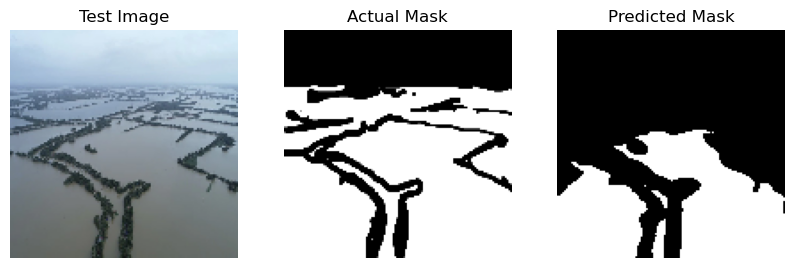

In [11]:
image_path = r"E:\Ragasudha\pictures\1078.jpg"
mask_path = r"E:\Ragasudha\pictures\1078.png"

test_images, test_masks = load_data(image_path, mask_path)
predictions = model.predict(test_images)
predictions = (predictions > 0.5).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(test_images[0])
plt.axis('off')
plt.title("Test Image")

plt.subplot(1, 3, 2)
plt.imshow(test_masks[0].squeeze(), cmap='gray')
plt.axis('off')
plt.title("Actual Mask")

plt.subplot(1, 3, 3)
plt.imshow(predictions[0].squeeze(), cmap='gray')
plt.axis('off')
plt.title("Predicted Mask")

plt.show()


In [12]:
def pixel_accuracy(true_masks, predicted_masks):
    true_masks_flat = true_masks.flatten()
    predicted_masks_flat = predicted_masks.flatten()
    accuracy = np.mean(true_masks_flat == predicted_masks_flat)
    return accuracy

accuracy = pixel_accuracy(test_masks, predictions)
print(f"Pixel-wise Accuracy: {accuracy * 100:.2f}%")


Pixel-wise Accuracy: 73.49%


In [13]:
def iou_score(true_masks, predicted_masks):
    intersection = np.logical_and(true_masks, predicted_masks)
    union = np.logical_or(true_masks, predicted_masks)
    iou = np.sum(intersection) / np.sum(union)
    return iou

iou = iou_score(test_masks, predictions)
print(f"IoU: {iou:.4f}")


IoU: 0.5671


In [24]:
def dice_coefficient(true_masks, predicted_masks):
    intersection = np.sum(true_masks * predicted_masks)
    dice = (2. * intersection) / (np.sum(true_masks) + np.sum(predicted_masks))
    return dice

# Example usage:
dice = dice_coefficient(test_masks, predictions)
print(f"Dice Coefficient: {dice:.4f}")


Dice Coefficient: 0.7797


In [26]:
import numpy as np

# Assuming test_masks and predictions are already loaded and predicted
# Both should be of shape (n_samples, height, width, 1)

# Pixel-wise accuracy function
def pixel_accuracy(true_masks, predicted_masks):
    true_masks_flat = true_masks.flatten()
    predicted_masks_flat = predicted_masks.flatten()
    accuracy = np.mean(true_masks_flat == predicted_masks_flat)
    return accuracy

# IoU (Intersection over Union) function
def iou_score(true_masks, predicted_masks):
    intersection = np.logical_and(true_masks, predicted_masks)
    union = np.logical_or(true_masks, predicted_masks)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Dice Coefficient function
def dice_coefficient(true_masks, predicted_masks):
    intersection = np.sum(true_masks * predicted_masks)
    dice = (2. * intersection) / (np.sum(true_masks) + np.sum(predicted_masks))
    return dice

# Calculate metrics
accuracy = pixel_accuracy(test_masks, predictions)
iou = iou_score(test_masks, predictions)
dice = dice_coefficient(test_masks, predictions)

# Print results
print(f"Pixel-wise Accuracy: {accuracy * 100:.2f}%")
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")


Pixel-wise Accuracy: 84.34%
IoU: 0.6361
Dice Coefficient: 0.7797
